# Part 1: Getting the data ready
The data is formatted in many files as json; let's put it into something easier to work with for NLP. 

In [0]:
# Uncomment and run this cell if you're on colab or kaggle.
# !pip install scispacy scipy
# !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_lg-0.2.4.tar.gz
# !pip install tqdm -U

In [0]:
# need for vectorization
import scispacy
import spacy

In [0]:
# need for processing
import pandas as pd 
import os
import numpy as np
import json
from tqdm.notebook import tqdm
import ipywidgets as widgets
from scipy.spatial import distance

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Walks all subdirectories in a directory, and their files. 
# Opens all json files we deem relevant, and append them to
# a list that can be used as the "data" argument in a call to 
# pd.DataFrame.

def gather_jsons(dirName):
    
    # Get the list of all files in directory tree at given path
    # include only json with encoded id (40-character SHA hash)
    # Only length of filename is checked, but this should be sufficient
    # given the task.
    
    listOfFiles = list()
    for (dirpath, dirnames, filenames) in os.walk(dirName):
        listOfFiles += [os.path.join(dirpath, file) for file in filenames
                        if file.endswith("json")
                        and len(file) == 45]
    jsons = []
    
    print(str(len(listOfFiles)) + " jsons found! Attempting to gather.")
    
    for file in tqdm(listOfFiles):
        with open(file) as json_file:
            jsons.append(json.load(json_file))
    return jsons
        
        
# Returns a dictionary object that's easy to parse in pandas.
def extract_from_json(json):
    
    # For text mining purposes, we're only interested in 4 columns:
    # abstract, paper_id (for ease of indexing), title, and body text.
    # In this particular dataset, some abstracts have multiple sections,
    # with ["abstract"][1] or later representing keywords or extra info. 
    # We only want to keep [0]["text"] in these cases. 
    if len(json["abstract"]) > 0:
        json_dict = {
            "_id": json["paper_id"],
            "title": json["metadata"]["title"],
            "abstract": json["abstract"][0]["text"],
            "text": " ".join([i["text"] for i in json["body_text"]])
        }
        
    # Else, ["abstract"] isn't a list and we can just grab the full text.
    else:
        json_dict = {
            "_id": json["paper_id"],
            "title": json["metadata"]["title"],
            "abstract": json["body_text"][0]["text"],
            "text": " ".join([i["text"] for i in json["body_text"]])
        }

    return json_dict

# Combines gather_jsons and extract_from_json to create a
# pandas DataFrame object.
def gather_data(dirName):
    return(pd.DataFrame(data=[extract_from_json(json) for json in gather_jsons(dirName)]))


def columnToArray(text):
  text = text.replace('\n', '')
  return np.fromstring(text[1:-1],dtype=np.float,sep=' ')

In [0]:
# If in Colab, uncomment this code: 
# !unzip -q -d "/content/drive/My Drive/covid_data/data"  "/content/drive/My Drive/covid_data/CORD-19-research-challenge.zip"
# df = gather_data("/content/drive/My Drive/covid_data/data")
# df.to_csv("/content/drive/My Drive/covid_data/covid_data_full.csv", index=False)

29315 jsons found! Attempting to gather.


In [0]:
# Uncomment if data already processed
# df = pd.read_csv("/content/drive/My Drive/covid_data/covid_data_full.csv")

# Part 2: Processing

Let's load our language model. Based on the type of text we'll be dealing with, we want something that's been pretrained on biomedical texts, as the vocabulary and statistical distribution of words is much different from, say, the news or Wikipedia articles. Luckily, there's already pre-trained models for spacy, so let's load the largest one we can! 

In [0]:
nlp = spacy.load("en_core_sci_lg")
# nlp = spacy.load("/usr/local/lib/python3.6/dist-packages/en_core_sci_lg/en_core_sci_lg-0.2.4")

One of the texts is particularly long, so we need to increase the max_length attribute of nlp to more then 1.25mil. The alternative would be cutting the length of the article or dropping it entirely (I believe there's some sort of anomaly with this particular article), but we'll keep it for now. 

In [0]:
nlp.max_length=2000000

### Texts vectorization
Appending to a dataframe increases time to copy data linearly because df.append copies the entire object. The following will take an article's text, break it into sentences, and vectorize each sentence (using scispacy's pre-trained word2vec model). Finally, the list of dicts is loaded as a DataFrame and saved.

In [0]:
CHUNKS_COUNT = 10

In [0]:
# chunk processing due to long processing time and possible notebook runtime shutdowns
chunks = np.array_split(df, CHUNKS_COUNT)
chunk_dfs = []
for index, chunk in enumerate(chunks):
  chunk = chunk.reset_index()
  vector_list = []
  for i in tqdm(chunk.index):
    doc = nlp(chunk.iloc[i].text)
    vector_list.append(
    {
    "_id": chunk.iloc[i]._id, 
    "vector": doc.vector,
    })
  vector_df = pd.DataFrame(data=vector_list)
  vector_df.to_json(f"/content/drive/My Drive/covid_data/covid_vectors_part_{index}.json")
  chunk_dfs.append(vector_df)
  del vector_list
  del vector_df

vector_df = pd.concat(chunk_dfs, axis=0, ignore_index=True)
vector_df.to_json(f"/content/drive/My Drive/covid_data/covid_vectors.json")

In [0]:
# if data already processed
# vector_df = pd.read_json(f"/content/drive/My Drive/covid_data/covid_vectors.json")

## Tasks vectorization

Let's vectorize tasks descriptions for calculating similarities between tasks and docs

In [0]:
with open('/content/drive/My Drive/covid_data/tasks.json', 'r') as f:
    tasks = json.load(f)

The following cell will vectorize each of our query sentences, and store those vectors in a DataFrame for us. That way, we have a numeric representation of the meaning of our queries, and they're conveniently indexed by number. Later, we can use these index numbers for cross-reference. 

In [0]:
tasks_vector_list = []
for i in tqdm(range(len(tasks))):
    task = tasks[i]
    doc = nlp(task["description"])
    vec = doc.vector
    tasks_vector_list.append({"_id": f"task_{i}", "title": task["title"], "vector": vec})
    
tasks_vector_df = pd.DataFrame(data=tasks_vector_list)
tasks_vector_df.to_json("/content/drive/My Drive/covid_data/tasks_vecs.json")

In [0]:
# Uncomment if data already processed
# tasks_vector_df = pd.read_json("/content/drive/My Drive/covid_data/tasks_vecs.json")  

## Measure similarity

We can calculate the vector cosine distances between all queries and sentences in the corpus. Cosine distance is a pretty typical measurement in NLP for the similarity between two vectors -- however, there are other measurements (Euclidean distance takes magnitude into consideration; cosine similarity only cares about the angle between pair-wise values on an axis). We'll go with cosine similarity for now.

In [0]:
distances = distance.cdist([value for value in tasks_vector_df["vector"]], [value for value in vector_df["vector"]], "cosine")
distances_by_doc = distance.cdist([value for value in vector_df["vector"]], [value for value in tasks_vector_df["vector"]], "cosine")

No need for the vector column any more. Let's free up some memory. 

In [0]:
w2v_searchable_df = vector_df.drop(columns=["vector"])

In [0]:
# Create a column with cosine distances for each query vs the sentence
for i in range(len(tasks)):
    w2v_searchable_df[f"task_{i}_distance"] = distances[i]
w2v_searchable_df.to_json("/content/drive/My Drive/covid_data/covid_w2v_searchable.json")

# Part 3: Getting Results

Now we can start to use our cosine similarity measurements! It's essentially like a search engine, but without the need for keywords, as long as you have a good idea what you're looking for. 



#### Run this cell below if you've already got the data from Part 1. 

In [0]:
import json
with open('/content/drive/My Drive/covid_data/tasks.json', 'r') as f:
    tasks = json.load(f)
df = pd.read_csv("/content/drive/My Drive/covid_data/covid_data_full.csv")
w2v_searchable_df = pd.read_json("/content/drive/My Drive/covid_data/covid_w2v_searchable.json")
tasks_vector_df = pd.read_json("/content/drive/My Drive/covid_data/tasks_vecs.json")
vector_df = pd.read_json("/content/drive/My Drive/covid_data/covid_vectors.json")

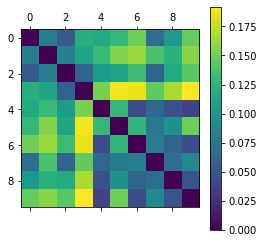

In [8]:
import matplotlib.pyplot as plt

tasks_distances = distance.cdist([value for value in tasks_vector_df["vector"]], [value for value in tasks_vector_df["vector"]], "cosine")
plt.matshow(tasks_distances);
plt.colorbar()
plt.show()


Let's check out our top results, and see if this was useful! Here we pass over each column, sorting for the highest values (most similar), and printing the top 10 hits. Are the results what we expect?


In [0]:
top_results_df = pd.DataFrame(columns=['task', 'rank', 'paper_id', 'similarity'])
row_number = 0

for i in range(len(tasks)):
    columnName = f"task_{i}_distance"
    sorted_df = w2v_searchable_df.sort_values(by=columnName)[:1000]
    ix = sorted_df["_id"].to_list()
    similarities = 1 - sorted_df[columnName]
    for j in range(len(context.index)):
        top_results_df.loc[row_number] = ['task_' + str(i)] + [str(j+1)] + [ix[j] + [similarities[j]]] 
        row_number = row_number + 1

top_results_df.to_json("/content/drive/My Drive/covid_data/results.json", orient='records')

In [0]:
top_results_df_docs = pd.DataFrame(columns=['paper_id', 'task', 'similarity'])
top_results_df_docs["paper_id"] = w2v_searchable_df["_id"]
top_results_df_docs["task"] = [np.argmin(dstances) for dstances in distances_by_doc]
top_results_df_docs["similarity"] = [1 - np.min(dstances) for dstances in distances_by_doc]
top_results_df_docs.to_json("/content/drive/My Drive/covid_data/results_docs.json", orient='records')